# Generative models

In [43]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from keras.metrics import categorical_accuracy


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Graficar imágenes:

In [19]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA como un autoencoder lineal

In [20]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Definir autoencoder:

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.4664
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0834 
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1174 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1674 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0856 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━

In [23]:
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Saving figure linear_autoencoder_pca_plot


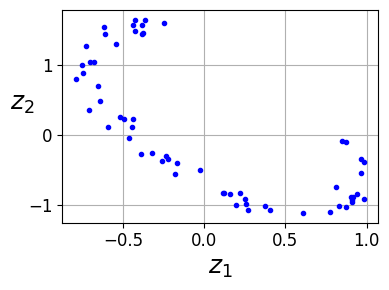

In [24]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked (Deep) Autoencoders

Utilizando MNIST:

In [25]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Stacked Autoencoder con 3 hidden layers y 1 output layer.

In [26]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [83]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(700, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(400, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(700, activation="selu", input_shape=[400]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mean_squared_error",# cada pixel como probailidad de membresia, por eso se usa cross entropy, converge mas rapido
                   optimizer=keras.optimizers.Adam(learning_rate=0.05), metrics=[categorical_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=40,
                         validation_data=(X_valid, X_valid))

Epoch 1/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - categorical_accuracy: 0.0789 - loss: 0.0608 - val_categorical_accuracy: 0.0567 - val_loss: 0.1686
Epoch 2/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.0943 - loss: 0.0275 - val_categorical_accuracy: 0.0740 - val_loss: 0.0432
Epoch 3/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.0972 - loss: 0.0256 - val_categorical_accuracy: 0.0938 - val_loss: 0.0256
Epoch 4/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.1000 - loss: 0.0245 - val_categorical_accuracy: 0.0951 - val_loss: 0.0238
Epoch 5/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.1031 - loss: 0.0234 - val_categorical_accuracy: 0.1098 - val_loss: 0.0242
Epoch 6/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.1070 - loss: 0.0222 - val_categorical_accuracy: 0.1171 - val_loss: 0.0212
Epoch 7/40
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accurac

Graficar reconstrucciones:

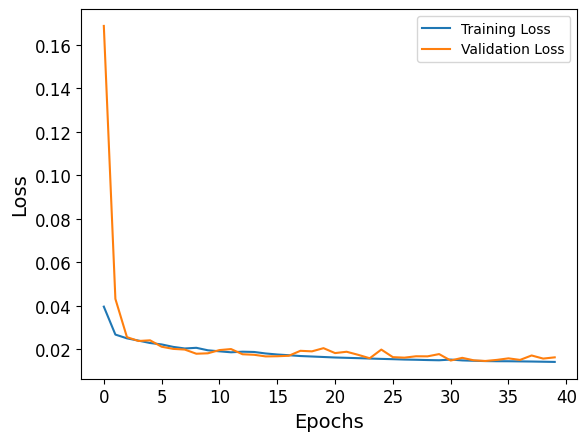

In [84]:
# Plot loss vs accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.plot(history.history['rounded_accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Saving figure reconstruction_plot


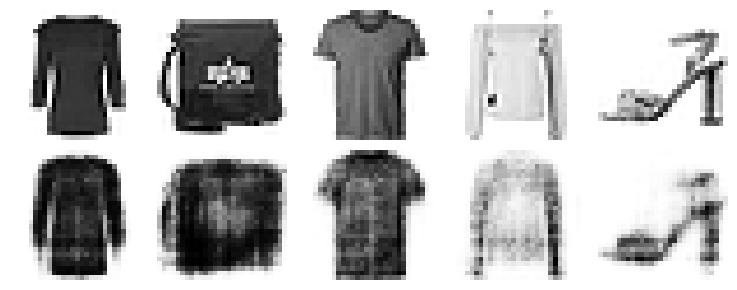

In [86]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizando Fashion MNIST con tsne desde espacio latente del encoder

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min()) #normalizar rango dinamico

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.01: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights (relacionadar pesos  en encoder y decoder)

Se fijan los pesos del decoder como la transpuesta de los pesos del encoder (relacón directa con pca como reconstructor).

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

In [ ]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [ ]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Autoencoders con CNNs

Nota: Para el decoder se debe incluir la operación de deconvolución o convolución transpuesta

![cnn](https://i.stack.imgur.com/YyCu2.gif)

![tcnn](https://i.stack.imgur.com/f2RiP.gif)

In [66]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=20,
                      validation_data=(X_valid, X_valid))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


2024-03-14 16:33:46.921424: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.087, expected 0.857533
2024-03-14 16:33:46.921474: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.20841, expected 0.97894
2024-03-14 16:33:46.921483: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 1.2056, expected 0.976126
2024-03-14 16:33:46.921492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 1.16297, expected 0.933496
2024-03-14 16:33:46.921500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 1.10739, expected 0.877919
2024-03-14 16:33:46.921508: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27: 1.08498, expected 0.855513
2024-03-14 16:33:46.921516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 1.23455, expected 1.00508
2024-03-14 16:33:46.921523: E external/local_xla/

1696/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3360 - rounded_accuracy: 0.8905

2024-03-14 16:33:52.872345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.56538, expected 1.25175
2024-03-14 16:33:52.872396: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.61393, expected 1.3003
2024-03-14 16:33:52.872406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.11396, expected 0.800333
2024-03-14 16:33:52.872414: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.71881, expected 1.40518
2024-03-14 16:33:52.872422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.51189, expected 1.19826
2024-03-14 16:33:52.872430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.92827, expected 1.61464
2024-03-14 16:33:52.872438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 2.03682, expected 1.72319
2024-03-14 16:33:52.872446: E external/local_xla/xla/s

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3355 - rounded_accuracy: 0.8909 - val_loss: 0.2835 - val_rounded_accuracy: 0.9316
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2768 - rounded_accuracy: 0.9397 - val_loss: 0.2745 - val_rounded_accuracy: 0.9417
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2713 - rounded_accuracy: 0.9452 - val_loss: 0.2720 - val_rounded_accuracy: 0.9446
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2684 - rounded_accuracy: 0.9483 - val_loss: 0.2701 - val_rounded_accuracy: 0.9473
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2665 - rounded_accuracy: 0.9505 - val_loss: 0.2680 - val_rounded_accuracy: 0.9500
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2650 - rounded_accuracy: 0.9522 - val_loss: 0.2667 - val_rounded_accuracy: 0.9516
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2639 - rounded_accuracy: 0.9534 - val_loss: 0.2656 - val_rounded_accur

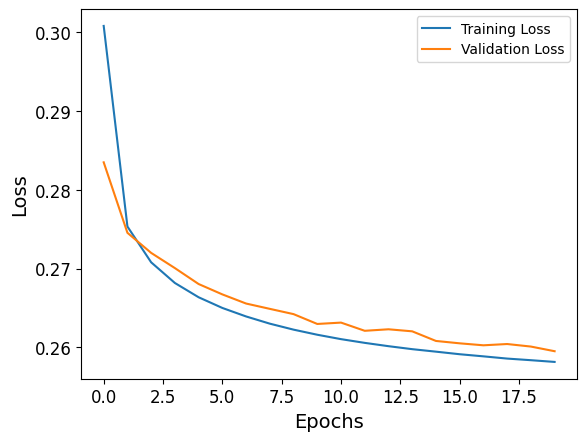

In [69]:
# Plot loss vs accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.plot(history.history['rounded_accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
conv_encoder.summary()
conv_decoder.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


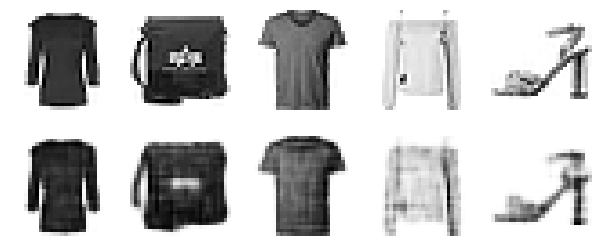

In [70]:
show_reconstructions(conv_ae)
plt.show()

# Stacked denoising Autoencoder

Se busca regularizar mediante ruido, generalmente Gaussiano, o aplicando dropout

Utilizando ruido Gaussiano:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), #std
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Con dropout:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

- Busca disminuir la cantidad de neuranas activas en el encoder.
- Se usa una sigmoid en el encoder con regularización l1
- Otras alternativas incluyen el mse con l1 y l2, o incluso la Divergencia KL sobre las activaciones de las neuronas para regularizar (sparse).

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(simple_ae)
plt.show()

Cálculo de histogramas para revisar la frecuencia de activación:

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Con regularización l1:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_l1_ae)

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Aplicar la divergencia KL para asegurar un 10% de sparsity

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_kl_ae)

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# [Variational Autoencoder](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)



Traditional Autoencoders deconstruct input data into a latent representation, and then using this latent space they reconstruct the original data. During this process, the Neural Network discovers which features are the most important for the reconstruction process and which ones can be ignored.
<div>
<img src=https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-030-31756-0_4/MediaObjects/480626_1_En_4_Fig2_HTML.png>
</div>

However, there are issues associated with the Latent Space: This latent space is not necesarily continuous between classes, and as such if a new data point lands in between classes, the network won't be able to handle it and will produce a garbage output.
<div>
<img src=https://miro.medium.com/v2/resize:fit:1400/1*xCjoga9IPyNUSiz9E7ao7A.png>
</div>

To solve this issue, Variational Autoencoders (VAE) try to force the latent space to a known probability distribution

The encoder normally produces a latent space, but in a VAE, the encoder produces a latent distribution $q(z|x)$, we then sample this distribution to create our latent space and reconstruct as normal.

<div>
<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*ejNnusxYrn1NRDZf4Kg2lw@2x.png" style="background-color:white;"/>
</div>




This latent distribution is compared to our posterior distribution $p(z|x)$ and through the cost function the goal is to minimize the difference between them.
$$q(z|x) ≈ p(z|x)$$

There is one big issue with this approach, thanks to Bayes' Theorem we know
$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$
Where $p(x|z)$ is our reconstruction likelihood

$p(z)$ is our prior known distribution

and $p(x)$ is the evidence

Calculating the evidence turns out to be imposible due to the intractable nature of the evidence.
$$p(x) = ∫p(x|z)p(z)dz$$

At some point we need to find a way to estimate this evidence. Let's take a step back however, and get as far as we can calculating $q(z|x) ≈ p(z|x)$. We know the Kullback-Leibler divergence acts as a pseudo-distance for probability density functions, so we can use it to estimate the difference between $q$ and $p$

$$D_{kl}(q||p) = 𝔼_q\{log\begin{pmatrix}\frac{q(z|x)}{p(z|x)}\end{pmatrix}\}$$
Since we know the evidence can't be calculated, let's manipulate the formula to try and isolate it. We know the $log$ of a quotient is equals to the difference between $logs$:

$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x) - log(p(z|x)\}$$


The Expectancy of a sum/subtraction is the sum/substraction of the expetancies:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(z|x)\}$$
Applying Bayes' Theorem to p(z|x):
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log\begin{pmatrix}\frac{p(x|z)p(z)}{p(x)}\end{pmatrix}\}$$
Once again separating the $log$ into a difference and splitting the Expectancy we get:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - (𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(p(x))\})$$
$$= 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + 𝔼_q\{log(p(x))\}$$

Now we expand $𝔼_q\{log(p(x))\}$ and get:

$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + \int q(z|x)log(p(x))dz$$
Since our evidence isn't in terms of $z$, we can pull it out of the integral:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + log(p(x))\int q(z|x)dz$$
and by definition, the integral of any density function is 1, so:
$$D_{kl}(q||p) = 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + log(p(x))\times 1$$
$$= 𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(x|z)p(z))\} + log(p(x))$$

Now we can estimate our evidence $p(x)$ by isolating it:

$$log(p(x)) = D_{kl}(q||p) + 𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$$

We can't calculate $D_{kl}(q||p)$ as discussed earlier, but we also know, since it is a pseudo-distance, that it will always be greater or equal to $0$, so we can estimate our evidence as:

$$log(p(x)) \geq 𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$$

This is what's known as the **Evidence Lower Bound (ELBO)**, and it tells us that by maximizing $𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$ we can not only approximate $p(x)$, but also minimize $D_{kl}(q||p)$. Now let us manipulate it a little bit more to make it easier to use:

$$ELBO = 𝔼_q\{log(p(x|z)p(z))\} - 𝔼_q\{log(q(z|x)\}$$
The $log$ of a product is the sum of the $logs$:
$$ELBO = 𝔼_q\{log(p(x|z)) + log(p(z))\} - 𝔼_q\{log(q(z|x)\}$$
Once again splitting the Expectancy:
$$ELBO = 𝔼_q\{log(p(x|z))\} + 𝔼_q\{log(p(z))\} - 𝔼_q\{log(q(z|x)\}$$
Now we reorder the equation:
$$ELBO = 𝔼_q\{log(p(x|z))\} - 𝔼_q\{log(q(z|x)\} + 𝔼_q\{log(p(z))\}$$
Factor the negative sign from the last two terms:
$$ELBO = 𝔼_q\{log(p(x|z))\} - (𝔼_q\{log(q(z|x)\} - 𝔼_q\{log(p(z))\})$$
And finally we rejoin the Expectancy and the $logs$ for our last two terms:
$$ELBO = 𝔼_q\{log(p(x|z))\} - 𝔼_q\{log\begin{pmatrix}\frac{q(z|x)}{p(z)}\end{pmatrix}\}$$

In this form we can easily see how our first term represents the negative crossentropy between $q(z|x)$ and $p(x|z)$, while the second represent the Kullback-Leibler divergence for our encoder output $q(z|x)$ and our known prior distribution $p(z)$. So maximizing the **ELBO** comes down to minimizing the reconstruction error and the KL Divergence between the latent distribution and our prior.

![vae](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*eRcdr8gczweQHk--1pZF9A@2x.png)

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Se generan puntos en el espacio latente y se reconstruyen las imágenes:

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Interpolación semántica: se pasan las imágenes por el encoder, se interpolan los dos puntos en el espacio latente, y la interpolación en el espacio latente se pasa por el decoder.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# [Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

Variational autoencoders fueron y son muy populares, pero las GANs surgen como una alternativa para generar imágenes más realistas.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # despues de compilar discriminator se entrena si se llama su .fit o su train_on_batch, no se  entrena en metodos de gan
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)


# Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)